# Project Introduction & Set Up

This notebook contains all the code for the data analysis and visualizations shown in the [Carlos Alcaraz vs. The Big 3](https://medium.com/towards-data-science/carlos-alcaraz-vs-the-big-3-138e50a8a429) article, published in Towards Data Science.

This analysis, or the article above, would not have been possible without Jeff Sackmann's work on tennis and the data shared in this [Github repository](https://github.com/JeffSackmann/tennis_atp).

## Global Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns=999
pd.options.display.max_rows=999

## The Data 

In [504]:
df = pd.DataFrame()

#Combining the individual files downloaded from Jeff's Github 
for i in range(1998,2024):
    df_temp = pd.read_csv(f'atp_matches_{i}.csv')
    df = pd.concat([df,df_temp],ignore_index=True)

In [505]:
df.shape

(77460, 49)

### Imputing Wimbledon Data

In [506]:
wim_impute = pd.DataFrame()

for p in ['Carlos Alcaraz','Novak Djokovic','Daniil Medvedev']:
    
    for i,j in zip(range(1,8),['R128','R64','R32','R16','QF','SF','F']):
        temp = pd.DataFrame({'tourney_id':'2023-0000',
                 'tourney_name':'Wimbledon',
                 'tourney_level':'G',
                 'tourney_date':20230703,
                 'match_num':i,
                 'winner_name':p,
                  'round':j},index=[0])
        wim_impute = pd.concat([wim_impute,temp])

wim_impute = wim_impute.reset_index(drop=True)
wim_impute = wim_impute.drop(index=[13,19,20])
wim_impute['loser_name']=''
wim_impute.loc[5,'loser_name']='Daniil Medvedev'
wim_impute.loc[6,'loser_name']='Novak Djokovic'
wim_impute = wim_impute.append(wim_impute[5:7],ignore_index=True)
wim_impute = wim_impute.drop(index=[5,6])
wim_impute.reset_index(drop=True,inplace=True)
wim_impute['match_num']=range(1,wim_impute.shape[0]+1)

wim_impute['score'] = ''
wim_impute.loc[14,'score']='W/O'

wim_impute['winner_age'] = ''
wim_impute.loc[0:4,'winner_age']=20.2 #Carlos age at wim 2023
wim_impute.loc[5:10,'winner_age']=36.1 #Novak age at wim 2023
wim_impute.loc[11:15,'winner_age']= 27.4 #Daniil age at wim 2023
wim_impute.loc[16:17,'winner_age']=20.2 #Carlos age at wim 2023
wim_impute['winner_age'] = wim_impute['winner_age'].astype(float)

df = pd.concat([df,wim_impute],ignore_index=True)
df.shape

(77478, 49)

In [508]:
#Adding a clean date column
df['Tourney_Date'] = pd.to_datetime(df['tourney_date'].astype(str))

#Adding a year column
df['Year'] = df['Tourney_Date'].dt.year

#Order data set by date and match number
df.sort_values(by=['Tourney_Date',
                   'tourney_name',
                  'match_num'],
              inplace=True)

#Cleaning up the incorrect spelling for the US Open
df['tourney_name'] = df['tourney_name'].str.replace('Us Open','US Open')

#Removing extra spaces from score column

df['score'] = df['score'].str.strip()

In [528]:
#Can use this cell to quickly check for any player's stats
player = 'Daniil Medvedev'
df[((df['winner_name']==f'{player}')|(df['loser_name']==f'{player}'))
   &(df['tourney_level'].isin(['G']))].shape

(88, 51)

## Players of interest

In [462]:
b3 = ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']

Top 10 on this website as of 7/17/23 <br>
https://www.atptour.com/en/rankings/singles

In [463]:
t10 = ['Carlos Alcaraz', 
       'Daniil Medvedev', 
       'Casper Ruud', 
       'Stefanos Tsitsipas', 
       'Holger Rune',
       'Andrey Rublev',
       'Jannik Sinner',
       'Taylor Fritz',
      'Frances Tiafoe',
       'Karen Khachanov']

In [8]:
t15 = ['Carlos Alcaraz', 
       'Daniil Medvedev', 
       'Casper Ruud', 
       'Stefanos Tsitsipas', 
       'Holger Rune',
       'Andrey Rublev',
       'Jannik Sinner',
       'Taylor Fritz',
      'Frances Tiafoe',
       'Karen Khachanov',
      'Felix Auger-Aliassime',
      'Cameron Norrie',
      'Borna Coric',
      'Lorenzo Musetti',
      'Alex de Minaur']

In [9]:
t20 = ['Carlos Alcaraz', 
       'Daniil Medvedev', 
       'Casper Ruud', 
       'Stefanos Tsitsipas', 
       'Holger Rune',
       'Andrey Rublev',
       'Jannik Sinner',
       'Taylor Fritz',
      'Frances Tiafoe',
       'Karen Khachanov',
      'Felix Auger-Aliassime',
      'Cameron Norrie',
      'Borna Coric',
      'Lorenzo Musetti',
      'Alex de Minaur',
      'Tommy Paul',
      'Hubert Hurkacz',
      'Francisco Cerundolo',
      'Pablo Carreno Busta',
      'Alexander Zverev']

In [10]:
t25 = ['Carlos Alcaraz', 
       'Daniil Medvedev', 
       'Casper Ruud', 
       'Stefanos Tsitsipas', 
       'Holger Rune',
       'Andrey Rublev',
       'Jannik Sinner',
       'Taylor Fritz',
      'Frances Tiafoe',
       'Karen Khachanov',
      'Felix Auger-Aliassime',
      'Cameron Norrie',
      'Borna Coric',
      'Lorenzo Musetti',
      'Alex de Minaur',
      'Tommy Paul',
      'Hubert Hurkacz',
      'Francisco Cerundolo',
      'Pablo Carreno Busta',
      'Alexander Zverev',
       'Jan-Lennard Struff',
      'Roberto Bautista Agut',
      'Grigor Dimitrov',
      'Sebastian Korda',
      'Alexander Bublik']

In [464]:
keyp = b3+t10 #this is the group of players we will focus on 

# Journeys Analysis

In [465]:
keyp

['Roger Federer',
 'Rafael Nadal',
 'Novak Djokovic',
 'Carlos Alcaraz',
 'Daniil Medvedev',
 'Casper Ruud',
 'Stefanos Tsitsipas',
 'Holger Rune',
 'Andrey Rublev',
 'Jannik Sinner',
 'Taylor Fritz',
 'Frances Tiafoe',
 'Karen Khachanov']

In [510]:
#Creating a tournament winners dataframe for Masters 1000s and Grand Slams to use for the journeys columns
t_winner_df = df[(df['round']=='F') & (df['tourney_level'].isin(['G','M']))][['tourney_id','Tourney_Date','tourney_level','tourney_name','winner_name']]
t_winner_df.rename(columns={'winner_name':'Tourney_Winner'},inplace=True)

In [511]:
t_winner_df.head(10)

,tourney_id,Tourney_Date,tourney_level,tourney_name,Tourney_Winner
250,1998-580,1998-01-19,G,Australian Open,Petr Korda
725,1998-404,1998-03-09,M,Indian Wells Masters,Marcelo Rios
820,1998-403,1998-03-16,M,Miami Masters,Marcelo Rios
1204,1998-410,1998-04-20,M,Monte Carlo Masters,Carlos Moya
1446,1998-414,1998-05-04,M,Hamburg Masters,Albert Costa
1509,1998-416,1998-05-11,M,Rome Masters,Marcelo Rios
1691,1998-520,1998-05-25,G,Roland Garros,Carlos Moya
1997,1998-540,1998-06-22,G,Wimbledon,Pete Sampras
2483,1998-421,1998-08-03,M,Canada Masters,Patrick Rafter
2538,1998-422,1998-08-10,M,Cincinnati Masters,Patrick Rafter


In [512]:
journeys_dict = {}

for i in keyp:
    player_df = df[((df['winner_name']==i)|(df['loser_name']==i))&
                  df['tourney_level'].isin(['G','M'])] #initial dataframe just at 1000 and grand slam level
    
    #Match Granularity Info
    player_df['Actual_Match_Flag'] = (player_df['score']!='W/O').astype(int) #Match played flag ignoring walkovers    
    player_df['Match_Win_Flag'] = 1 
    player_df['Match_Win_Flag'].mask((player_df['loser_name'] == i)|(player_df['Actual_Match_Flag']==0),
                                     0, inplace=True) #Match win flag
    player_df['Match_Count_By_Tourney_Type'] = player_df.groupby('tourney_level')['Actual_Match_Flag'].cumsum() #Match count by tourney type 
    player_df['Match_Win_Count_By_Tourney_Type'] = player_df.groupby('tourney_level')['Match_Win_Flag'].cumsum() #Match win count by tourney type

    #Tournament Granularity (requires a temp table)
    temp_df = player_df[['tourney_id','Tourney_Date','tourney_level','tourney_name']].drop_duplicates()
    temp_df = pd.merge(left=temp_df, right=t_winner_df, how='left', on='tourney_id') #joining with tourney winners table above  
    
    temp_df['Tourney_Win_Flag'] = (temp_df['Tourney_Winner']==i).astype(int) #Tournament win flag 
    temp_df['Tourney_Count_By_Type'] = temp_df.groupby('tourney_level_x').cumcount()+1 #Tournaments played by type
    temp_df['Tourney_Win_Count_By_Type']=temp_df.groupby('tourney_level_x')['Tourney_Win_Flag'].cumsum() #Tournament wins by type
    
    
    #Combining match granularity and tournament granularity into one data frame
    player_df = pd.merge(left=player_df, right=temp_df, how='inner', on='tourney_id' ).drop(columns=
                                                                            ['Tourney_Date_x','tourney_level_x',
                                                                             'tourney_name_x','Tourney_Date_y',
                                                                            'tourney_level_y','tourney_name_y'])
    
    #Saving the dataframe into the dictionary
    journeys_dict[i] = player_df 


<ipython-input-512-9eefc23a9ec6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['Actual_Match_Flag'] = (player_df['score']!='W/O').astype(int) #Match played flag ignoring walkovers
<ipython-input-512-9eefc23a9ec6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['Match_Win_Flag'] = 1
/Users/abhisawhney/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:9286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

<ipython-input-512-9eefc23a9ec6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['Actual_Match_Flag'] = (player_df['score']!='W/O').astype(int) #Match played flag ignoring walkovers
<ipython-input-512-9eefc23a9ec6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['Match_Win_Flag'] = 1
/Users/abhisawhney/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:9286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

In [469]:
journeys_dict['Daniil Medvedev'].shape

(207, 59)

In [470]:
player = 'Daniil Medvedev'
df[((df['winner_name']==f'{player}')|(df['loser_name']==f'{player}'))
   &(df['tourney_level'].isin(['G','M']))].shape

(207, 51)

In [471]:
journeys_dict['Carlos Alcaraz']

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,Tourney_Date,Year,Actual_Match_Flag,Match_Win_Flag,Match_Count_By_Tourney_Type,Match_Win_Count_By_Tourney_Type,Tourney_Winner,Tourney_Win_Flag,Tourney_Count_By_Type,Tourney_Win_Count_By_Type
0,2021-580,Australian Open,Hard,128.0,G,20210208,150,207989.0,NaN,Q,Carlos Alcaraz,R,185.0,ESP,17.7,122298.0,NaN,Q,Botic Van De Zandschulp,R,188.0,NED,25.3,6-1 6-4 6-4,5.0,R128,114.0,2.0,1.0,84.0,48.0,37.0,23.0,14.0,3.0,4.0,4.0,6.0,90.0,49.0,35.0,16.0,13.0,7.0,12.0,141.0,484.0,151.0,461.0,2021-02-08,2021,1,1,1,1,Novak Djokovic,0,1,0
1,2021-580,Australian Open,Hard,128.0,G,20210208,189,144707.0,NaN,NaN,Mikael Ymer,R,183.0,SWE,22.4,207989.0,NaN,Q,Carlos Alcaraz,R,185.0,ESP,17.7,2-6 6-4 6-4 7-6(5),5.0,R64,188.0,2.0,8.0,132.0,88.0,56.0,19.0,20.0,7.0,15.0,7.0,5.0,133.0,83.0,52.0,22.0,20.0,10.0,18.0,95.0,775.0,141.0,484.0,2021-02-08,2021,1,0,2,1,Novak Djokovic,0,1,0
2,2021-0403,Miami Masters,Hard,128.0,M,20210322,220,200325.0,NaN,NaN,Emil Ruusuvuori,R,188.0,FIN,21.9,207989.0,NaN,WC,Carlos Alcaraz,R,185.0,ESP,17.8,6-4 2-6 7-5,3.0,R128,131.0,1.0,4.0,94.0,65.0,42.0,15.0,15.0,3.0,6.0,2.0,4.0,83.0,53.0,37.0,16.0,15.0,4.0,7.0,83.0,881.0,132.0,561.0,2021-03-22,2021,1,0,1,0,Hubert Hurkacz,0,1,0
3,2021-1536,Madrid Masters,Clay,64.0,M,20210503,268,207989.0,NaN,WC,Carlos Alcaraz,R,185.0,ESP,17.9,105173.0,NaN,NaN,Adrian Mannarino,L,183.0,FRA,32.8,6-4 6-0,3.0,R64,71.0,1.0,1.0,42.0,26.0,21.0,11.0,8.0,0.0,0.0,1.0,1.0,58.0,32.0,14.0,14.0,8.0,3.0,7.0,120.0,654.0,34.0,1681.0,2021-05-03,2021,1,1,2,1,Alexander Zverev,0,2,0
4,2021-1536,Madrid Masters,Clay,64.0,M,20210503,285,104745.0,1.0,NaN,Rafael Nadal,L,185.0,ESP,34.9,207989.0,NaN,WC,Carlos Alcaraz,R,185.0,ESP,17.9,6-1 6-2,3.0,R32,77.0,1.0,3.0,45.0,26.0,21.0,11.0,8.0,2.0,3.0,0.0,3.0,38.0,22.0,9.0,5.0,7.0,2.0,7.0,2.0,9810.0,120.0,654.0,2021-05-03,2021,1,0,3,1,Alexander Zverev,0,2,0
5,2021-520,Roland Garros,Clay,128.0,G,20210531,129,207989.0,NaN,Q,Carlos Alcaraz,R,185.0,ESP,18.0,126523.0,NaN,Q,Bernabe Zapata Miralles,R,185.0,ESP,24.3,6-3 2-6 6-1 7-6(4),5.0,R128,188.0,2.0,6.0,137.0,84.0,50.0,30.0,18.0,6.0,12.0,3.0,2.0,118.0,77.0,46.0,17.0,18.0,7.0,15.0,97.0,815.0,128.0,631.0,2021-05-31,2021,1,1,3,2,Novak Djokovic,0,2,0
6,2021-520,Roland Garros,Clay,128.0,G,20210531,178,207989.0,NaN,Q,Carlos Alcaraz,R,185.0,ESP,18.0,105932.0,28.0,NaN,Nikoloz Basilashvili,R,185.0,GEO,29.2,6-4 6-2 6-4,5.0,R64,116.0,10.0,1.0,81.0,55.0,43.0,13.0,14.0,4.0,6.0,0.0,4.0,84.0,47.0,28.0,20.0,14.0,6.0,12.0,97.0,815.0,31.0,1785.0,2021-05-31,2021,1,1,4,3,Novak Djokovic,0,2,0
7,2021-520,Roland Garros,Clay,128.0,G,20210531,203,105526.0,NaN,NaN,Jan Lennard Struff,R,193.0,GER,31.0,207989.0,NaN,Q,Carlos Alcaraz,R,185.0,ESP,18.0,6-4 7-6(3) 6-2,5.0,R32,136.0,10.0,3.0,94.0,42.0,35.0,27.0,15.0,5.0,8.0,3.0,1.0,100.0,59.0,31.0,24.0,15.0,5.0,11.0,42.0,1500.0,97.0,815.0,2021-05-31,2021,1,0,5,3,Novak Djokovic,0,2,0
8,2021-540,Wimbledon,Grass,128.0,G,20210628,162,207989.0,NaN,WC,Carlos Alcaraz,R,185.0,ESP,18.1,106034.0,NaN,LL,Yasutaka Uchiyama,R,183.0,JPN,28.8,6-3 6-7(4) 6-2 3-6 6-3,5.0,R128,258.0,6.0,5.0,169.0,101.0,67.0,33.0,23.0,17.0,23.0,8.0,4.0,186.0,106.0,68.0,34.0,25.0,13.0,23.0,75.0,924.0,116.0,697.0,2021-06-28,2021,1,1,6,4,Novak Djokovic,0,3,0
9,2021-540,Wimbledon,Grass,128.0,G,20210628,195,106421.0,2.0,NaN,Daniil Medvedev,R,198.0,RUS,25.3,207989.0,NaN,WC,Carlos Alcaraz,R,185.0,ESP,18.1,6-4 6-1 6-2,5.0,R64,95.0,6.0,3.0,64.0,40.0,38.0,10.0,13.0,1.0,3.0,2.0,5.0,82.0,55.0,34.0,7.0,12.0,8.0,15.0,2.0,10280.0,75.0,924.0,2021-06-28,2021,1,0,7,4,Novak Djokovic,0,3,0


# Article Visualizations

In [472]:
import matplotlib.style as style
style.use('default')
style.use('fivethirtyeight')

## Chart 1 - Grand Slam Winners Since 2003 

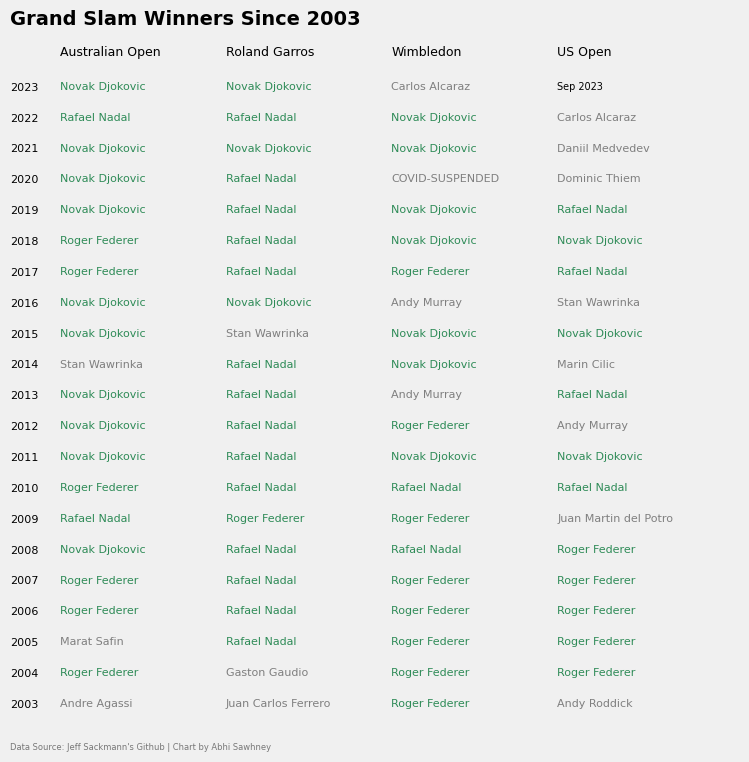

In [224]:
#Creating the dataset to plot
ch1 = df[(df['tourney_level']=='G')&
  (df['round']=='F')&
  (df['Year'] >= 2003)][['Year','tourney_name','winner_name']]

ch1.reset_index(inplace=True,drop=True)
wim_susp = pd.DataFrame(data=[2020,'Wimbledon','COVID-SUSPENDED']).T #adding suspended wimbledon to dataset
wim_susp.columns = ch1.columns
ch1 = pd.concat([ch1,wim_susp],ignore_index=True)


ch1.sort_values(by='Year',inplace=True)
ch1['count'] = 1

ch1_p = ch1.pivot_table(index='Year',columns='tourney_name')
#ch1_p.sort_index(ascending=False,inplace=True) #so we can go in ascending order in a hbar
ch1_p = ch1_p[[('count','Australian Open'),
              ('count','Roland Garros'),
              ('count','Wimbledon'),
               ('count','US Open')]] #reordering in the order of the slams



#Plotting the visual
style.use('fivethirtyeight')

ch1_p.plot(kind='barh',stacked=True, 
           color = ["#72A0C1"],
           #color = ["#1E8FD5","#CB5223","#84B118","#3C638E"], 
           alpha=0,
           figsize=(8,8),
          legend=None)

# plt.legend(['Australian Open','Roland Garros','Wimbledon','US Open'],
          #bbox_to_anchor=(1.02, 1), loc='upper left',borderaxespad=0, fontsize=10)

#Title
plt.text(x=-0.2, y=22, s='Grand Slam Winners Since 2003', weight='bold', size=14)
plt.text(x=0.1, y=21.0, s='Australian Open', size=9)#, weight='bold')
plt.text(x=1.1, y=21.0, s='Roland Garros', size=9)#, weight='bold')
plt.text(x=2.1, y=21.0, s='Wimbledon', size=9)#, weight='bold')
plt.text(x=3.1, y=21.0, s='US Open', size=9)#, weight='bold')


#Formatting Chart
plt.ylabel('')
plt.yticks(fontsize=8)
plt.xticks([])
plt.grid(False)


aus_winners = list(ch1[ch1['tourney_name']=='Australian Open']['winner_name'])
french_winners = list(ch1[ch1['tourney_name']=='Roland Garros']['winner_name'])
wim_winners = list(ch1[ch1['tourney_name']=='Wimbledon']['winner_name'])
us_winners = list(ch1[ch1['tourney_name']=='US Open']['winner_name'])

#Winner Names Text
y=-0.1
for p in aus_winners:
    if p in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']:
        plt.text(x=0.1, y=y, s=p, size=8, color='seagreen')#, alpha=1, weight='bold')
    else:
        plt.text(x=0.1, y=y, s=p, size=8, color='tab:grey')#, style='italic')#, weight='bold')#, color='white'
    y+=1

y=-0.1
for p in french_winners:
    if p in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']:
        plt.text(x=1.1, y=y, s=p, size=8, color='seagreen')#, alpha=1, weight='bold')
    else:
        plt.text(x=1.1, y=y, s=p, size=8, color='tab:grey')#, style='italic')#, weight='bold')#, color='white', alpha=1)    
    y+=1

y=-0.1    
for p in wim_winners:
    if p in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']:
        plt.text(x=2.1, y=y, s=p, size=8, color='seagreen')#, alpha=1, weight='bold')
    else:
        plt.text(x=2.1, y=y, s=p, size=8, color='tab:grey')#, style='italic')#, weight='bold')#, color='white', alpha=1)
    y+=1
    
y=-0.1
for p in us_winners:
    if p in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']:
        plt.text(x=3.1, y=y, s=p, size=8, color='seagreen')#, alpha=1, weight='bold')
    else:
        plt.text(x=3.1, y=y, s=p, size=8, color='tab:grey')#, style='italic')#, weight='bold')#, color='white', alpha=1)
    y+=1


#TBD Text
plt.text(x=3.1, y=19.9, s='Sep 2023', size=7)#, weight='bold')

 
#Signature bar at the botom with background color
plt.text(-0.2, -1.5, s='Data Source: Jeff Sackmann\'s Github | Chart by Abhi Sawhney', size=6, alpha=0.5)#, backgroundcolor = 'whitesmoke')#, style='italic')


plt.show()

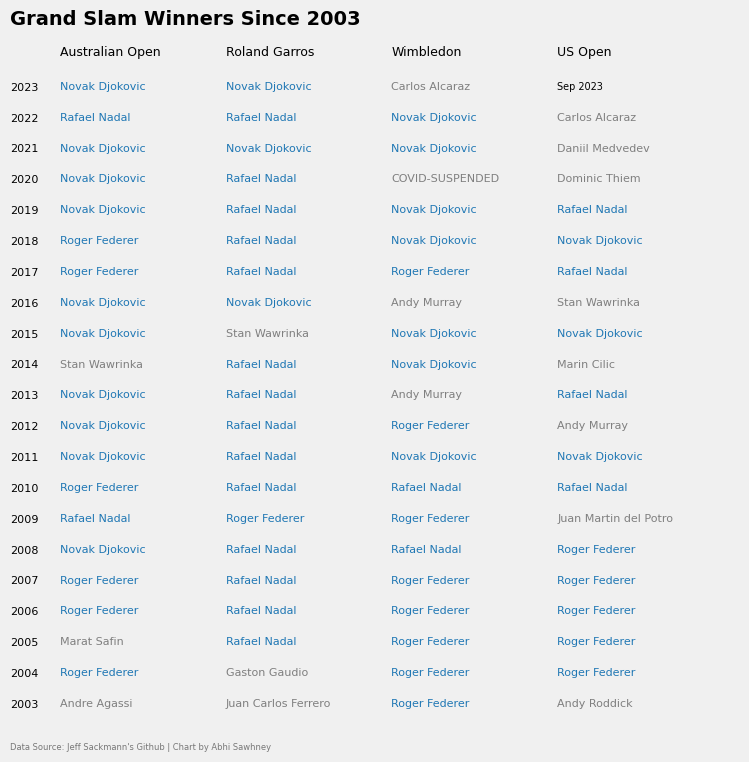

In [228]:
#Creating the dataset to plot
ch1 = df[(df['tourney_level']=='G')&
  (df['round']=='F')&
  (df['Year'] >= 2003)][['Year','tourney_name','winner_name']]

ch1.reset_index(inplace=True,drop=True)
wim_susp = pd.DataFrame(data=[2020,'Wimbledon','COVID-SUSPENDED']).T #adding suspended wimbledon to dataset
wim_susp.columns = ch1.columns
ch1 = pd.concat([ch1,wim_susp],ignore_index=True)


ch1.sort_values(by='Year',inplace=True)
ch1['count'] = 1

ch1_p = ch1.pivot_table(index='Year',columns='tourney_name')
#ch1_p.sort_index(ascending=False,inplace=True) #so we can go in ascending order in a hbar
ch1_p = ch1_p[[('count','Australian Open'),
              ('count','Roland Garros'),
              ('count','Wimbledon'),
               ('count','US Open')]] #reordering in the order of the slams



#Plotting the visual
style.use('fivethirtyeight')

ch1_p.plot(kind='barh',stacked=True, 
           color = ["#72A0C1"],
           #color = ["#1E8FD5","#CB5223","#84B118","#3C638E"], 
           alpha=0,
           figsize=(8,8),
          legend=None)

# plt.legend(['Australian Open','Roland Garros','Wimbledon','US Open'],
          #bbox_to_anchor=(1.02, 1), loc='upper left',borderaxespad=0, fontsize=10)

#Title
plt.text(x=-0.2, y=22, s='Grand Slam Winners Since 2003', weight='bold', size=14)
plt.text(x=0.1, y=21.0, s='Australian Open', size=9)#, weight='bold')
plt.text(x=1.1, y=21.0, s='Roland Garros', size=9)#, weight='bold')
plt.text(x=2.1, y=21.0, s='Wimbledon', size=9)#, weight='bold')
plt.text(x=3.1, y=21.0, s='US Open', size=9)#, weight='bold')


#Formatting Chart
plt.ylabel('')
plt.yticks(fontsize=8)
plt.xticks([])
plt.grid(False)


aus_winners = list(ch1[ch1['tourney_name']=='Australian Open']['winner_name'])
french_winners = list(ch1[ch1['tourney_name']=='Roland Garros']['winner_name'])
wim_winners = list(ch1[ch1['tourney_name']=='Wimbledon']['winner_name'])
us_winners = list(ch1[ch1['tourney_name']=='US Open']['winner_name'])

#Winner Names Text
y=-0.1
for p in aus_winners:
    if p in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']:
        plt.text(x=0.1, y=y, s=p, size=8, color='tab:blue')#, alpha=1, weight='bold')
    else:
        plt.text(x=0.1, y=y, s=p, size=8, color='tab:grey')#, style='italic')#, weight='bold')#, color='white'
    y+=1

y=-0.1
for p in french_winners:
    if p in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']:
        plt.text(x=1.1, y=y, s=p, size=8, color='tab:blue')#, alpha=1, weight='bold')
    else:
        plt.text(x=1.1, y=y, s=p, size=8, color='tab:grey')#, style='italic')#, weight='bold')#, color='white', alpha=1)    
    y+=1

y=-0.1    
for p in wim_winners:
    if p in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']:
        plt.text(x=2.1, y=y, s=p, size=8, color='tab:blue')#, alpha=1, weight='bold')
    else:
        plt.text(x=2.1, y=y, s=p, size=8, color='tab:grey')#, style='italic')#, weight='bold')#, color='white', alpha=1)
    y+=1
    
y=-0.1
for p in us_winners:
    if p in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']:
        plt.text(x=3.1, y=y, s=p, size=8, color='tab:blue')#, alpha=1, weight='bold')
    else:
        plt.text(x=3.1, y=y, s=p, size=8, color='tab:grey')#, style='italic')#, weight='bold')#, color='white', alpha=1)
    y+=1


#TBD Text
plt.text(x=3.1, y=19.9, s='Sep 2023', size=7)#, weight='bold')

 
#Signature bar at the botom with background color
plt.text(-0.2, -1.5, s='Data Source: Jeff Sackmann\'s Github | Chart by Abhi Sawhney', size=6, alpha=0.5)#, backgroundcolor = 'whitesmoke')#, style='italic')
# plt.text(2.2, -1.2, s='Data current as of June 30th 2023 | Chart by Abhi Sawhney', color = '#f0f0f0', backgroundcolor = '#4d4d4d', size=7, style='italic')
# plt.text(2.2, -1, s='Data current as of June 30th 2023 | Chart by Abhi Sawhney', color='black', 
#         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

plt.show()

## Chart 2 - Grand Slams and Masters 1000 Counts for Key Players

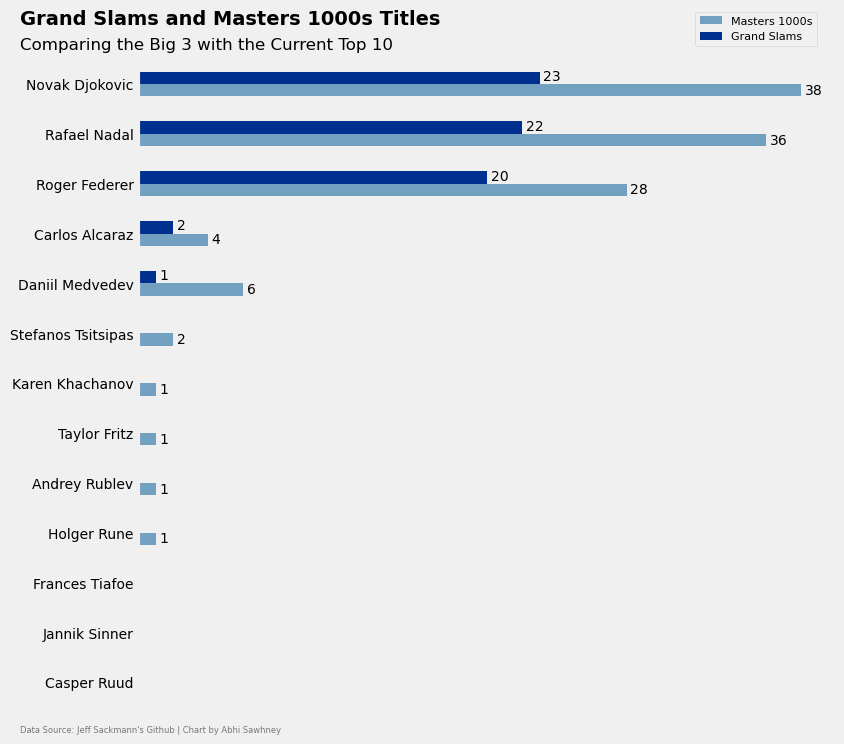

In [307]:
ch2_gs = df[(df['tourney_level']=='G') & 
            (df['winner_name'].isin(keyp)) & 
            (df['round']=='F')]['winner_name'].value_counts()

ch2_m1000 = df[(df['tourney_level']=='M') &
        (df['winner_name'].isin(keyp)) &
        (df['round']=='F')]['winner_name'].value_counts()


ch2 = pd.DataFrame(index=keyp)
ch2 = pd.concat([ch2,ch2_m1000],axis=1)
ch2 = pd.concat([ch2,ch2_gs],axis=1)
ch2.columns = ['Masters_1000', 'Grand_Slams']
ch2.fillna(0,inplace=True)
ch2.sort_values(['Grand_Slams','Masters_1000'],inplace=True)

#Viz
ch2.plot.barh(figsize=(8,8),color=['#72A0C1','#00308F'],alpha=1)
# plt.barh(ch2.index, ch2['Grand_Slams'])
# plt.barh(ch2.index, ch2['Masters_1000'])

#Overall Title & Subtitle
plt.text(x=-6.8, y=13.2, s='Grand Slams and Masters 1000s Titles', weight='bold', size=14)
plt.text(x=-6.8, y=12.7, s='Comparing the Big 3 with the Current Top 10', size=12)

#Axes
# plt.xlabel('Tournament Wins', fontsize=12)
# plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks(fontsize=10)
plt.grid(False)


#Adding grand slam count label
plt.text(x=23.2, y=12.08, s='23',fontsize=10)#, weight='bold') #Novak
plt.text(x=22.2, y=11.08, s='22',fontsize=10)#, weight='bold') #Rafa
plt.text(x=20.2, y=10.08, s='20',fontsize=10)#, weight='bold') #Roger
plt.text(x=2.2, y=9.08, s='2',fontsize=10)#, weight='bold') #Carlos
plt.text(x=1.2, y=8.08, s='1',fontsize=10)#, weight='bold') #Med

#Adding M1000 label
plt.text(x=38.2, y=11.8, s='38',fontsize=10)#, weight='bold') #Novak
plt.text(x=36.2, y=10.8, s='36',fontsize=10)#, weight='bold') #Rafa
plt.text(x=28.2, y=9.8, s='28',fontsize=10)#, weight='bold') #Roger
plt.text(x=4.2, y=8.8, s='4',fontsize=10)#, weight='bold') #Carlos
plt.text(x=6.2, y=7.8, s='6',fontsize=10)#, weight='bold') #Med

plt.text(x=2.2, y=6.8, s='2',fontsize=10)#, weight='bold') #Tsit
plt.text(x=1.2, y=5.8, s='1',fontsize=10)#, weight='bold') #Kach
plt.text(x=1.2, y=4.8, s='1',fontsize=10)#, weight='bold') #Fritz
plt.text(x=1.2, y=3.8, s='1',fontsize=10)#, weight='bold') #Rublev
plt.text(x=1.2, y=2.8, s='1',fontsize=10)#, weight='bold') #Rune

#Legend

# plt.legend(['Masters 1000s', 'Grand Slams'],bbox_to_anchor=(1.02, 1), loc='upper left',borderaxespad=0, fontsize=10)
plt.legend(['Masters 1000s', 'Grand Slams'], fontsize=8, loc=(0.8, 1.02))

#Signature bar at the botom with background color
plt.text(-6.8, -1, s='Data Source: Jeff Sackmann\'s Github | Chart by Abhi Sawhney', size=6, alpha=0.5)

plt.show()

## Chart 3 - Masters 1000

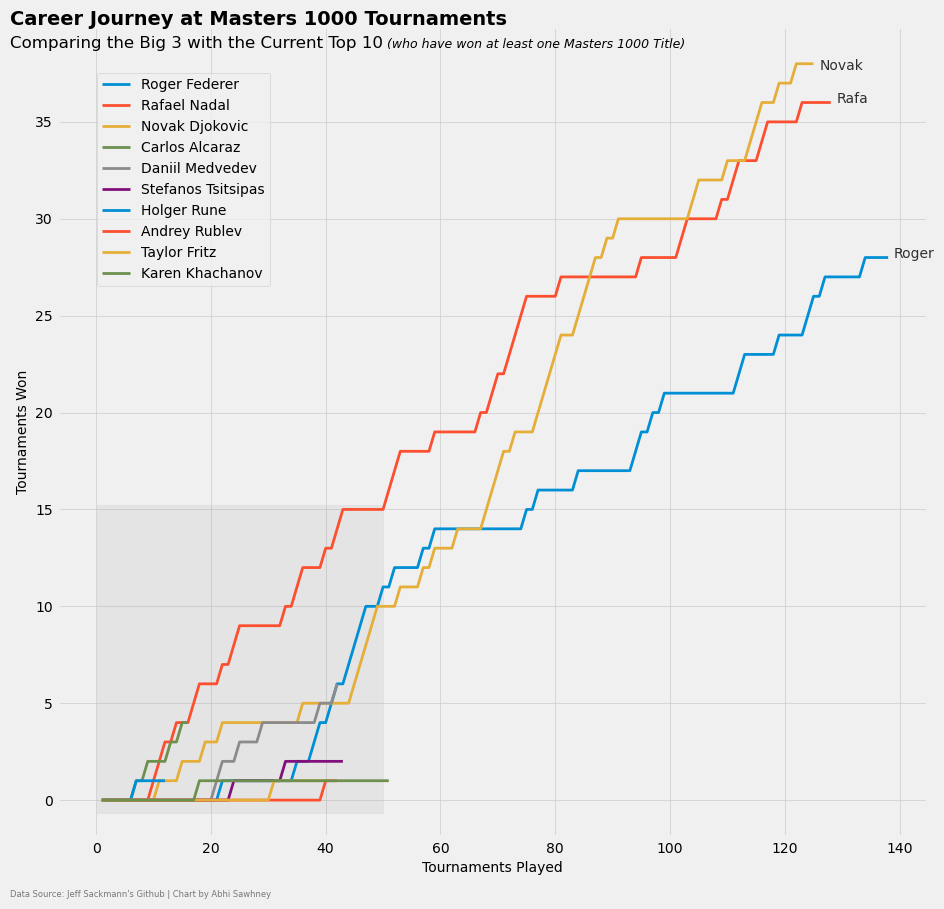

In [361]:
#Masters 1000 Tournament Winners Out of Current Top 10 and Big 3

plt.figure(figsize=(10,10))

for p in ['Roger Federer',
 'Rafael Nadal',
 'Novak Djokovic',
 'Carlos Alcaraz',
 'Daniil Medvedev',
 'Stefanos Tsitsipas',
 'Holger Rune',
 'Andrey Rublev',
 'Taylor Fritz',
 'Karen Khachanov']:
    temp_df = journeys_dict[p]
    temp_df = temp_df[temp_df['tourney_level']=='M']
    x = temp_df['Tourney_Count_By_Type']
    y = temp_df['Tourney_Win_Count_By_Type']
    plt.plot(x,y,label=p, linewidth=2,alpha=1)


#Overall Title & Subtitle
plt.text(x=-15, y=40, s='Career Journey at Masters 1000 Tournaments', weight='bold', size=14)
plt.text(x=-15, y=38.8, s='Comparing the Big 3 with the Current Top 10', size=12)
plt.text(x=50, y=38.8, s=' (who have won at least one Masters 1000 Title)', size=9,style='italic')


#x and y axis
plt.xlabel('Tournaments Played', fontsize=10)
# plt.text(x=58, y=-4, s='Tournaments Played', fontsize=10)
plt.ylabel('Tournaments Won', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.legend(fontsize=10, loc=(0.045, 0.68))
plt.grid(b=True, linewidth=0.5)
# plt.grid(False)

#Identifying the big tree
plt.text(x=126, y=37.7, s='Novak',fontsize=10,alpha=0.8)#, weight='bold') #Novak
plt.text(x=129, y=36, s='Rafa',fontsize=10,alpha=0.8)#, weight='bold') #Rafa
plt.text(x=139, y=28, s='Roger',fontsize=10,alpha=0.8)#, weight='bold') #Roger

#Highlighting bottom left quadrant
plt.axvspan(xmin=.2,xmax=50,ymin=0.03,ymax=.41,alpha=0.1,color='grey')

#Signature bar at the botom with background color
plt.text(-15, -5, s='Data Source: Jeff Sackmann\'s Github | Chart by Abhi Sawhney', size=6, alpha=0.5)

plt.show()

## Chart 4 - Masters 1000 Zoomed In

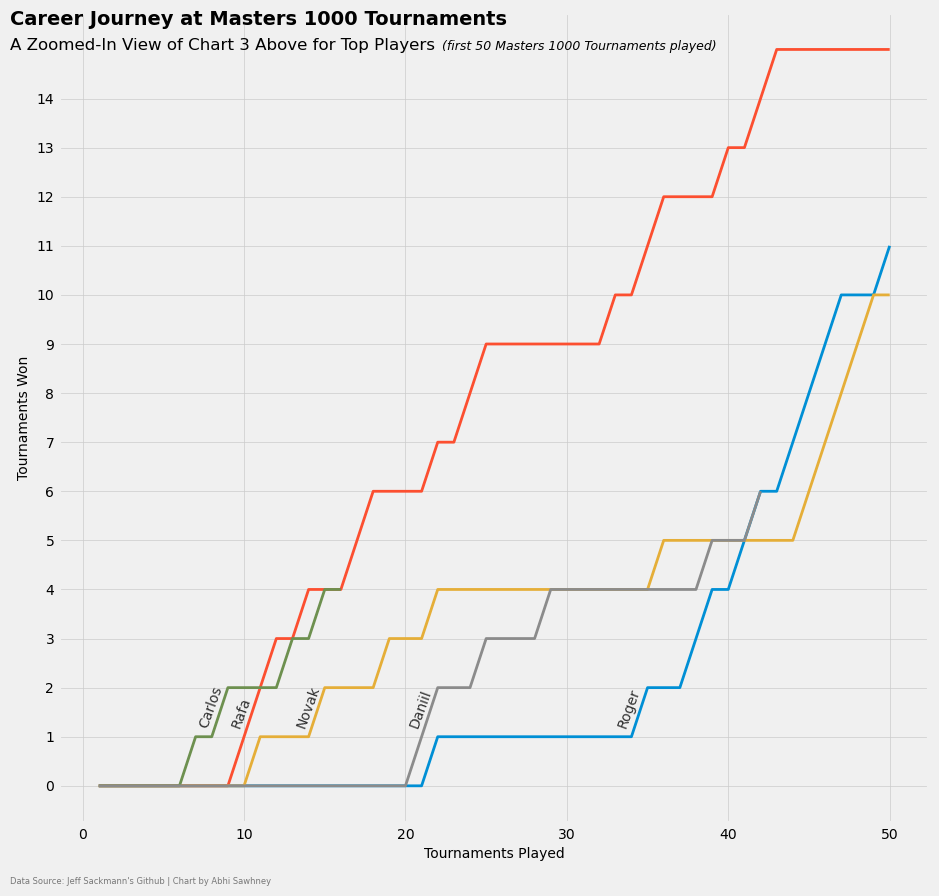

In [583]:
#Masters 1000 Tournament Winners Out of Current Top 10 and Big 3

plt.figure(figsize=(10,10))

for p in ['Roger Federer',
 'Rafael Nadal',
 'Novak Djokovic',
 'Carlos Alcaraz',
 'Daniil Medvedev']:
    temp_df = journeys_dict[p]
    temp_df = temp_df[(temp_df['tourney_level']=='M')&
                     (temp_df['Tourney_Count_By_Type']<=50)]
    x = temp_df['Tourney_Count_By_Type']
    y = temp_df['Tourney_Win_Count_By_Type']
    plt.plot(x,y,label=p, linewidth=2,alpha=1)

#Overall Title & Subtitle
plt.text(x=-4.5, y=15.5, s='Career Journey at Masters 1000 Tournaments', weight='bold', size=14)
plt.text(x=-4.5, y=15, s='A Zoomed-In View of Chart 3 Above for Top Players', size=12)
plt.text(x=22, y=15, s=' (first 50 Masters 1000 Tournaments played)', size=9,style='italic')

#x and y axis
plt.xlabel('Tournaments Played', fontsize=10)
plt.ylabel('Tournaments Won', fontsize=10)
plt.yticks(fontsize=10)
plt.yticks(np.arange(0,15))
plt.xticks(fontsize=10)
plt.grid(b=True, linewidth=0.5)

#Identifying the players
plt.text(x=7.1, y=1.2, s='Carlos',fontsize=10,alpha=0.8, rotation=70)#, weight='bold') #Carlos
plt.text(x=9.1, y=1.2, s='Rafa',fontsize=10,alpha=0.8, rotation=70)#, weight='bold') #Rafa
plt.text(x=13.1, y=1.2, s='Novak',fontsize=10,alpha=0.8, rotation=70)#, weight='bold') #Novak
plt.text(x=20.1, y=1.2, s='Daniil',fontsize=10,alpha=0.8, rotation=70)#, weight='bold') #Daniil
plt.text(x=33.0, y=1.2, s='Roger',fontsize=10,alpha=0.8, rotation=70)#, weight='bold') #Roger

#Signature bar at the botom with background color
plt.text(-4.5, -2, s='Data Source: Jeff Sackmann\'s Github | Chart by Abhi Sawhney', size=6, alpha=0.5)

# plt.legend(fontsize=10, loc=(0.03, 0.78))
plt.show()

## Chart 5 - Grand Slam Journey

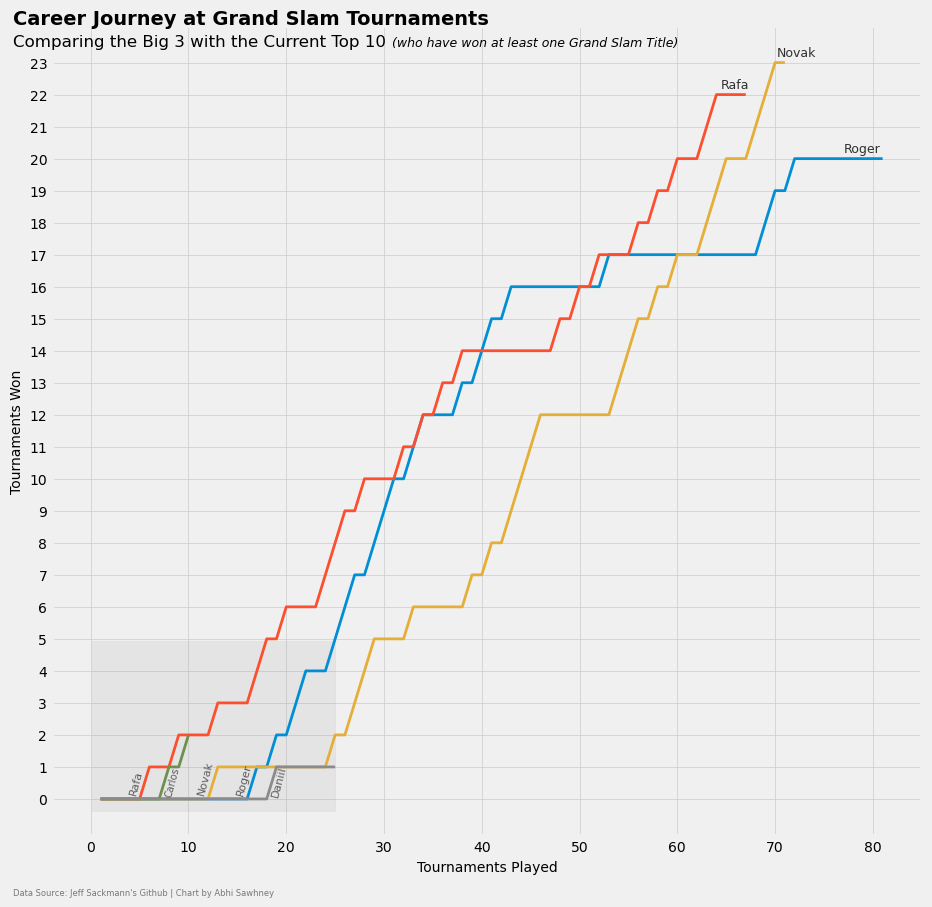

In [589]:
plt.figure(figsize=(10,10))

for p in ['Roger Federer',
 'Rafael Nadal',
 'Novak Djokovic',
 'Carlos Alcaraz',
 'Daniil Medvedev']:
    temp_df = journeys_dict[p]
    temp_df = temp_df[temp_df['tourney_level']=='G']
    x = temp_df['Tourney_Count_By_Type']
    y = temp_df['Tourney_Win_Count_By_Type']
    plt.plot(x,y,label=p, linewidth=2,alpha=1)


#Overall Title & Subtitle
plt.text(x=-8, y=24.2, s='Career Journey at Grand Slam Tournaments', weight='bold', size=14)
# plt.text(x=-8, y=23.5, s='Comparing the Big 3 with the Current Top 10 (who have at least one Grand Slam Title)', size=12)
plt.text(x=-8, y=23.5, s='Comparing the Big 3 with the Current Top 10', size=12)
plt.text(x=30.4, y=23.5, s=' (who have won at least one Grand Slam Title)', size=9,style='italic')

#x and y axis
plt.xlabel('Tournaments Played', fontsize=10)
plt.ylabel('Tournaments Won', fontsize=10)
plt.yticks(fontsize=10)
plt.yticks(np.arange(0,24,1))

plt.xticks(fontsize=10)
plt.grid(b=True, lw=0.5)

#Identifying the players
plt.text(x=3.8, y=0.15, s='Rafa',fontsize=8,alpha=0.6, rotation=75)#, weight='bold') #Rafa bottom
plt.text(x=64.4, y=22.2, s='Rafa',fontsize=9,alpha=0.8)#, weight='bold') #Rafa top

plt.text(x=7.5, y=0.1, s='Carlos',fontsize=7,alpha=0.6, rotation=75)#, weight='bold') #Carlos


plt.text(x=10.8, y=0.15, s='Novak',fontsize=8,alpha=0.6, rotation=75)#, weight='bold') #Novak
plt.text(x=70.2, y=23.2, s='Novak',fontsize=9,alpha=0.8)#, weight='bold') #Novak top


plt.text(x=18.4, y=0.1, s='Daniil',fontsize=8,alpha=0.6, rotation=75)#, weight='bold') #Daniil

plt.text(x=14.8, y=0.15, s='Roger',fontsize=8,alpha=0.6, rotation=75)#, weight='bold') #Roger
plt.text(x=77, y=20.2, s='Roger',fontsize=9,alpha=0.8)#, weight='bold') #Roger top


#Highlighting bottom left quadrant
plt.axvspan(xmin=.1,xmax=25,ymin=0.03,ymax=.24,alpha=0.1,color='grey')


#Signature bar at the botom with background color
plt.text(-8, -3, s='Data Source: Jeff Sackmann\'s Github | Chart by Abhi Sawhney', size=6, alpha=0.5)


# plt.legend(fontsize=10, loc=(0.04, 0.80))
plt.show()

## Chart 6 - Grand Slam Matches Journey

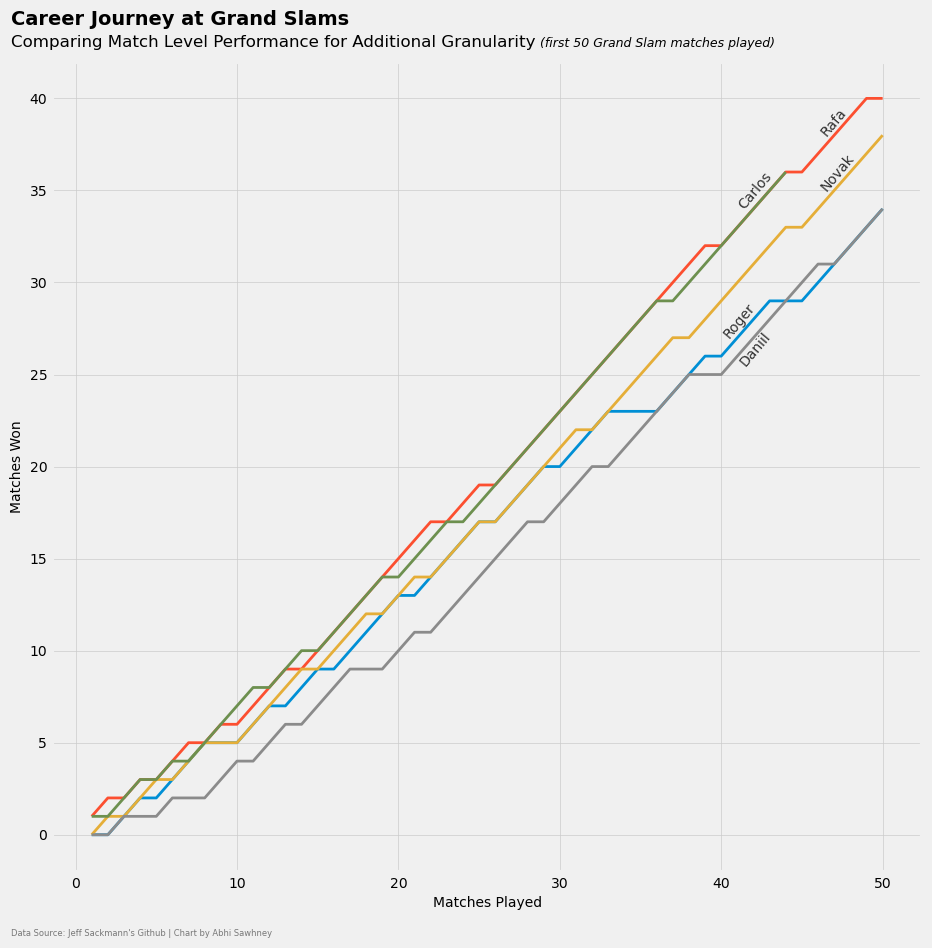

In [585]:
plt.figure(figsize=(10,10))

for p in ['Roger Federer',
 'Rafael Nadal',
 'Novak Djokovic',
 'Carlos Alcaraz',
 'Daniil Medvedev']:
    temp_df = journeys_dict[p]
    temp_df = temp_df[(temp_df['tourney_level']=='G')&
                     (temp_df['Match_Count_By_Tourney_Type']<=50)]
    x = temp_df['Match_Count_By_Tourney_Type']
    y = temp_df['Match_Win_Count_By_Tourney_Type']
    plt.plot(x,y,label=p, linewidth=2,alpha=1)


#Overall Title & Subtitle
plt.text(x=-4, y=44, s='Career Journey at Grand Slams', weight='bold', size=14)
plt.text(x=-4, y=42.8, s='Comparing Match Level Performance for Additional Granularity', size=12)
plt.text(x=28.5, y=42.8, s=' (first 50 Grand Slam matches played)', size=9,style='italic')


#x and y axis
plt.xlabel('Matches Played', fontsize=10)
plt.ylabel('Matches Won', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.grid(b=True, lw=0.5)

#Identifying the players
plt.text(x=40.9, y=34, s='Carlos',fontsize=10,alpha=0.8, rotation=50)#, weight='bold') #Carlos
plt.text(x=46, y=38, s='Rafa',fontsize=10,alpha=0.8, rotation=50)#, weight='bold') #Rafa
plt.text(x=46, y=35, s='Novak',fontsize=10,alpha=0.8, rotation=50)#, weight='bold') #Novak
plt.text(x=40, y=27, s='Roger',fontsize=10,alpha=0.8, rotation=50)#, weight='bold') #Roger
plt.text(x=41, y=25.5, s='Daniil',fontsize=10,alpha=0.8, rotation=50)#, weight='bold') #Daniil

# plt.legend(fontsize=10, loc=(0.03, 0.83))

#Signature bar at the botom with background color
plt.text(-4, -5.5, s='Data Source: Jeff Sackmann\'s Github | Chart by Abhi Sawhney', size=6, alpha=0.5)

plt.show()

## Chart 7 - Exploring the Age Angle

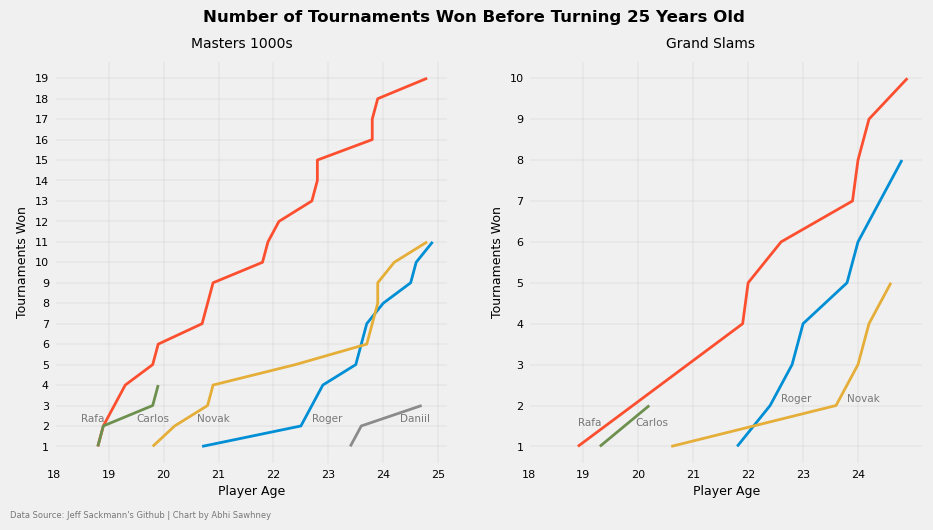

In [587]:
plt.figure(figsize=(10,5))
plt.suptitle('Number of Tournaments Won Before Turning 25 Years Old', fontsize=12, weight='bold')

plt.subplot(1,2,1)
for p in ['Roger Federer','Rafael Nadal', 'Novak Djokovic', 'Carlos Alcaraz', 'Daniil Medvedev']:
    temp_df = journeys_dict[p]
    temp_df = temp_df[(temp_df['tourney_level']=='M') &
            (temp_df['round']=='F') &
            (temp_df['winner_name']==p) &
            (temp_df['winner_age']<25)]
    
    x = temp_df['winner_age']
    y = temp_df['Tourney_Win_Count_By_Type']
    
    plt.plot(x,y,label=p, linewidth=2,alpha=1)
    


#Overall Title 
plt.text(x=20.5, y=20.5, s='Masters 1000s', size=10)

#x and y axis
plt.xlabel('Player Age', fontsize=9)
plt.xticks(fontsize=8)
plt.xticks(np.arange(18,26,step=1))

plt.ylabel('Tournaments Won', fontsize=9)
plt.yticks(fontsize=8)
plt.yticks(np.arange(1,20))
plt.grid(b=True, lw=0.3)

#Identifying the players
plt.text(x=18.5, y=2.2, s='Rafa',fontsize=7.5,alpha=0.5)#, weight='bold') #Rafa 
plt.text(x=19.5, y=2.2, s='Carlos',fontsize=7.5,alpha=0.5)#, weight='bold') #Carlos 
plt.text(x=20.6, y=2.2, s='Novak',fontsize=7.5,alpha=0.5)#, weight='bold') #Novak
plt.text(x=22.7, y=2.2, s='Roger',fontsize=7.5,alpha=0.5)#, weight='bold') #Roger
plt.text(x=24.3, y=2.2, s='Daniil',fontsize=7.5,alpha=0.5)#, weight='bold') #Daniil


#Signature bar at the botom with background color
plt.text(17.2, -2.5, s='Data Source: Jeff Sackmann\'s Github | Chart by Abhi Sawhney', size=6, alpha=0.5)


#------------------------

plt.subplot(1,2,2)
for p in ['Roger Federer','Rafael Nadal', 'Novak Djokovic', 'Carlos Alcaraz', 'Daniil Medvedev']:
    temp_df = journeys_dict[p]
    temp_df = temp_df[(temp_df['tourney_level']=='G') &
            (temp_df['round']=='F') &
            (temp_df['winner_name']==p)&
            (temp_df['winner_age']<25)]
    
    x = temp_df['winner_age']
    y = temp_df['Tourney_Win_Count_By_Type']
    
    plt.plot(x,y,label=p, linewidth=2,alpha=1)
    


#Overall Title & Subtitle
plt.text(x=20.5, y=10.75, s='Grand Slams', size=10)
# plt.text(x=18, y=23.5, s='Comparing the Big 3 with the Current Top 10 (who have won at least one Grand Slam Title)', size=12)

#x and y axis
plt.xlabel('Player Age', fontsize=9)
plt.xticks(fontsize=8)
plt.xticks(np.arange(18,25,step=1))

plt.ylabel('Tournaments Won', fontsize=9)
plt.yticks(fontsize=8)
plt.yticks(np.arange(1,11,step=1))
plt.grid(b=True, lw=0.3)

plt.text(x=18.9, y=1.5, s='Rafa',fontsize=7.5,alpha=0.5)#, weight='bold') #Rafa 
plt.text(x=19.95, y=1.5, s='Carlos',fontsize=7.5,alpha=0.5)#, weight='bold') #Carlos 
plt.text(x=23.8, y=2.1, s='Novak',fontsize=7.5,alpha=0.5)#, weight='bold') #Novak
plt.text(x=22.6, y=2.1, s='Roger',fontsize=7.5,alpha=0.5)#, weight='bold') #Roger


plt.show()

In [562]:
#Saving Data Sets Into CSVs
df.to_csv('Combined Dataset_7_26_23.csv',index=False)

In [564]:
df.shape

(77478, 51)

In [570]:
journeys_df = pd.DataFrame()

for p in keyp:
    t_df = journeys_dict[p]
    t_df['player_journey']=p
    journeys_df = journeys_df.append(t_df,ignore_index=True)

journeys_df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,Tourney_Date,Year,Actual_Match_Flag,Match_Win_Flag,Match_Count_By_Tourney_Type,Match_Win_Count_By_Tourney_Type,Tourney_Winner,Tourney_Win_Flag,Tourney_Count_By_Type,Tourney_Win_Count_By_Type,player_journey
0,1999-403,Miami Masters,Hard,96.0,M,19990315,12,102202.0,NaN,NaN,Kenneth Carlsen,L,190.0,DEN,25.9,103819.0,NaN,WC,Roger Federer,R,185.0,SUI,17.5,7-5 7-6(4),3.0,R128,102.0,6.0,1.0,76.0,45.0,34.0,18.0,12.0,5.0,7.0,6.0,6.0,104.0,54.0,39.0,22.0,12.0,11.0,14.0,106.0,461.0,125.0,366.0,1999-03-15,1999,1,0,1,0,Richard Krajicek,0,1,0,Roger Federer
1,1999-410,Monte Carlo Masters,Clay,56.0,M,19990419,13,102434.0,NaN,NaN,Vincent Spadea,R,183.0,USA,24.7,103819.0,NaN,WC,Roger Federer,R,185.0,SUI,17.6,7-6(3) 6-0,3.0,R64,65.0,1.0,0.0,54.0,33.0,27.0,16.0,9.0,0.0,0.0,0.0,2.0,62.0,33.0,20.0,15.0,9.0,4.0,7.0,33.0,1088.0,128.0,367.0,1999-04-19,1999,1,0,2,0,Gustavo Kuerten,0,2,0,Roger Federer
2,1999-520,Roland Garros,Clay,128.0,G,19990524,48,102158.0,3.0,NaN,Patrick Rafter,R,185.0,AUS,26.4,103819.0,NaN,WC,Roger Federer,R,185.0,SUI,17.7,5-7 6-3 6-0 6-2,5.0,R128,133.0,6.0,3.0,117.0,84.0,59.0,20.0,18.0,7.0,9.0,3.0,3.0,108.0,60.0,37.0,24.0,17.0,10.0,17.0,3.0,3298.0,111.0,424.0,1999-05-24,1999,1,0,1,0,Andre Agassi,0,1,0,Roger Federer
3,1999-540,Wimbledon,Grass,128.0,G,19990621,50,102562.0,NaN,NaN,Jiri Novak,R,190.0,CZE,24.2,103819.0,NaN,WC,Roger Federer,R,185.0,SUI,17.8,6-3 3-6 4-6 6-3 6-4,5.0,R128,138.0,1.0,5.0,171.0,130.0,85.0,16.0,24.0,17.0,21.0,8.0,6.0,160.0,108.0,77.0,22.0,23.0,10.0,15.0,59.0,779.0,103.0,457.0,1999-06-21,1999,1,0,2,0,Pete Sampras,0,2,0,Roger Federer
4,2000-580,Australian Open,Hard,128.0,G,20000117,52,103819.0,NaN,NaN,Roger Federer,R,185.0,SUI,18.4,102021.0,NaN,NaN,Michael Chang,R,175.0,USA,27.9,6-4 6-4 7-6(5),5.0,R128,125.0,14.0,7.0,101.0,55.0,42.0,28.0,16.0,1.0,3.0,6.0,9.0,120.0,74.0,52.0,22.0,16.0,5.0,9.0,62.0,620.0,38.0,841.0,2000-01-17,2000,1,1,3,1,Andre Agassi,0,3,0,Roger Federer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4107,2023-520,Roland Garros,Clay,128.0,G,20230529,124,111575.0,11,NaN,Karen Khachanov,R,198.0,RUS,27.0,106005.0,NaN,NaN,Constant Lestienne,R,180.0,FRA,31.0,3-6 1-6 6-2 6-1 6-3,5.0,R128,NaN,15.0,2.0,128.0,84.0,55.0,19.0,20.0,5.0,12.0,2.0,6.0,146.0,87.0,45.0,29.0,20.0,14.0,23.0,11.0,2945.0,70.0,769.0,2023-05-29,2023,1,1,78,54,Novak Djokovic,0,25,0,Karen Khachanov
4108,2023-520,Roland Garros,Clay,128.0,G,20230529,176,111575.0,11,NaN,Karen Khachanov,R,198.0,RUS,27.0,105430.0,NaN,Q,Radu Albot,R,175.0,MDA,33.5,6-3 6-4 6-2,5.0,R64,NaN,6.0,2.0,81.0,53.0,42.0,18.0,14.0,1.0,1.0,4.0,4.0,103.0,64.0,43.0,15.0,13.0,8.0,12.0,11.0,2945.0,113.0,564.0,2023-05-29,2023,1,1,79,55,Novak Djokovic,0,25,0,Karen Khachanov
4109,2023-520,Roland Garros,Clay,128.0,G,20230529,202,111575.0,11,NaN,Karen Khachanov,R,198.0,RUS,27.0,106423.0,NaN,WC,Thanasi Kokkinakis,R,196.0,AUS,27.1,6-4 6-1 3-6 7-6(5),5.0,R32,NaN,5.0,3.0,120.0,77.0,50.0,29.0,19.0,4.0,7.0,6.0,1.0,138.0,79.0,54.0,26.0,19.0,12.0,17.0,11.0,2945.0,108.0,587.0,2023-05-29,2023,1,1,80,56,Novak Djokovic,0,25,0,Karen Khachanov
4110,2023-520,Roland Garros,Clay,128.0,G,20230529,215,111575.0,11,NaN,Karen Khachanov,R,198.0,RUS,27.0,132283.0,NaN,NaN,Lorenzo Sonego,R,191.0,ITA,28.0,1-6 6-4 7-6(7) 6-1,5.0,R16,NaN,12.0,1.0,132.0,76.0,57.0,28.0,19.0,10.0,14.0,8.0,5.0,121.0,74.0,51.0,23.0,17.0,8.0,12.0,11.0,2945.0,48.0,

In [571]:
journeys_df.to_csv('Journeys Dataset_7_26_23.csv',index=False)